# On the Distribution Function of Order Statistics

Let $Z_{(1)}, \ldots, Z_{(n)}$ denote the [order statistics](https://en.wikipedia.org/wiki/Order_statistic) of a collection of independent random variables, $Z_{1}, \ldots, Z_{n}$ with distribution functions $F_1, \ldots F_n$.

In other words, the order statistics are drawn as follows,
$$
\begin{align*}
& Z_{1} \sim F_1; \ldots; Z_{n} \sim F_n \\
& Z_{(1)}, \ldots, Z_{(n)} = \mathrm{sort}\left( Z_{1}, \ldots, Z_{n} \right)
\end{align*}
$$

In this short post, we look at the distribution function of $Z_{(k)}$.
$$
F_{(k)}(t) \overset{\mathrm{def}}{=} \mathrm{Pr}\left( Z_{(k)} \le t \right) 
$$

There is no shortage of lecture notes and books online that describe the distribution functions for $Z_{(0)}$ (min) and $Z_{(n)}$ (max) as these cases are particularly simple and more commonly used.  The more general case turns out to not be too much harder.  Why do *I* care about this problem?  These distribution functions arise when analyzing order-based sampling without replacement designs, such as the [Gumbel-top-k design](https://timvieira.github.io/blog/tag/gumbel.html) that I have written about many times.  

Before continuing, I should note that my derivation and implementation draws heavily on [Aires (1999)](https://link.springer.com/article/10.1023/A:1010091628740); specifically, Lemma 2.

Without further ado...

We can expand the distribution function as follows,
$$
\mathrm{Pr}\left( Z_{(k)} \le t \right) =
\sum_{ Y \in {n \choose k} } 
  \underbrace{\left( \prod_{i \in Y} F_i(t) \right)}_{k \text{ values } \le t}
  \underbrace{\left( \prod_{i \in \overline{Y} } \left(1-F_i(t)\right) \right)}_{n-k \text{ values } > t}
$$
It is a sum over all the ways in which $t$ can be the $k^{\text{th}}$ order statistics: there must be exactly $k$ values that are $\le t$, and $n-k$ values that are larger than $t$.  These events are mutually exclusive and exhaustive.  Let $Y$ be the set of variables that are $\le t$. Because the $Z_i$s are independent, the probability of the event that $Y$ is the set of $k$ smallest elements is simply the product of the $F_i$s in $Y$ and $(1-F_i)$s in the complement of $Y$.

It turns out that we can evaluate the exponential-size sum in $\mathcal{O}(n k)$ time with a simple algorithm, which is essentially a *probabilistic generalization* of the dynamic program for evaluating the binomial coefficients, ${n \choose k}$.  Furthermore, we can evaluate the distribution function for *all* $n$ order statistics in $\mathcal{O}(n^2)$ time.  The code for doing this computation is below.

## Code

In [1]:
class Ordered:
    def __init__(self, ds: 'list of distributions'):
        self.ds = ds
    def sample(self, size=None):
        return np.sort(self.sample_keys(size), axis=0).T
    def sample_keys(self, size=None):
        return np.array([d.rvs(size) for d in self.ds])
    def F(self, t):
        """
        Evaluate the CDF of the order statistics, 
          Pr[ Z_{(k)} ≤ t ] for k = 1 ... N
        """
        return prob_binom([d.cdf(t) for d in self.ds])

In [2]:
def prob_binom(p):
    """
    Evaluate the probabilistic binomial coefficients, 
    {p \choose k} for k=1...n.
    """
    n = len(p)
    F = np.zeros((N+1, N+1))
    F[0,:] = 1.0
    for k in range(1, N+1):
        for n in range(N):
            F[k, n+1] = F[k,n] * (1-p[n]) + p[n] * F[k-1,n]
    F = F[1:, N]   # remove padding
    return F

## Tests

Below, we test out our analytical method for computing the distribution function of independent normal distributions.  The method should work for any collection of distributions in `scipy.stats`.  You can even mix and match the distribution types.  We will compare the analytical $F_{(k)}$ to the empirical distribution of $Z_{(k)}$ using a large sample size.

In [3]:
import scipy.stats as st, numpy as np, pylab as pl
from numpy.random import uniform
N = 16
m = Ordered([st.norm(uniform(-1, 1), uniform(0, 1)) for i in range(N)])

I will use my [arsenal library](https://github.com/timvieira/arsenal/blob/5f70cf6b1465f3eea20acec58c58c3c055c611ab/arsenal/maths/rvs.py#L280) to fit the empirical distribution function.

In [4]:
from arsenal.maths import Empirical
reps = 10_000
S = m.sample(reps).T
E = [Empirical(S[k]) for k in range(N)]

In [5]:
ts = np.linspace(S.min(), S.max(), 500)
F = np.array([m.F(t) for t in ts]).T

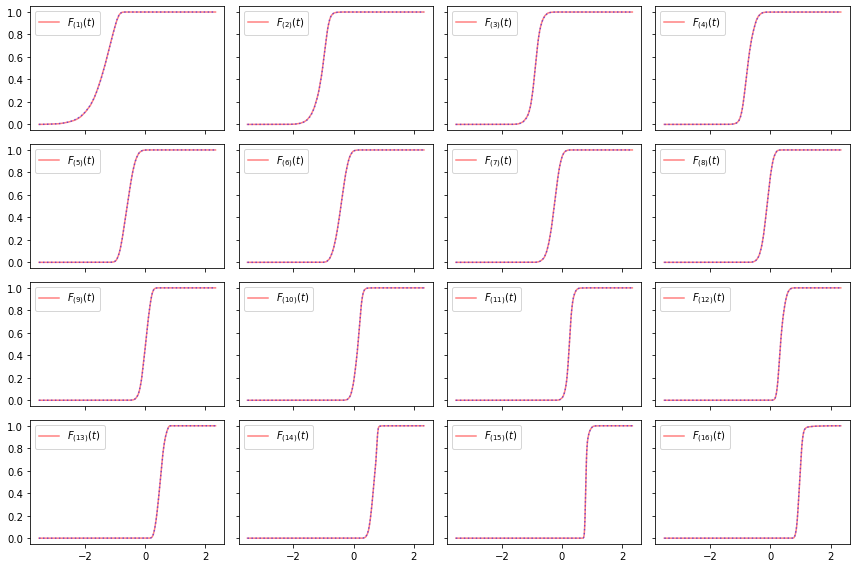

In [6]:
C = 4
fig, ax = pl.subplots(figsize=(12,8), nrows=int(np.ceil(N/C)), ncols=C, 
                      sharex=True, sharey=True)
for k in range(N):
    ax[k//C,k%C].plot(ts, E[k].cdf(ts), c='r', alpha=0.5, 
                      label = r'$F_{(%s)}(t)$' % (k+1))
    ax[k//C,k%C].plot(ts, F[k], c='b', alpha=0.5, linestyle=':')
    ax[k//C,k%C].legend(loc='best')
fig.tight_layout();

In the plots above, the red line is the empirical distribution funciton, and the blue dotted line is the analytical distribution function.  In all cases, we see that the fit is good.